## Transformer-Based Image Captioning
The model architecture is composed of two elements:
- A pre-trained CNN (frozen weights) to create image embeddings
- Transformer layers to generate meaningful captions based on the image embedding

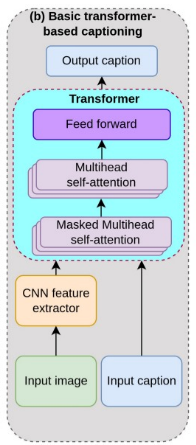

### Environment

In [1]:
!nvidia-smi

Thu Jun 27 13:16:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   51C    P5             40W /  170W |     713MiB /  12288MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights, resnet101, ResNet101_Weights
from tqdm import tqdm
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import nltk
import re
import string

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('DEVICE:\n{}'.format(device))

DEVICE:
cuda


### Data Exploration (Flickr30k)
TODO: Explore distribution of caption lengths, vocabulary size, and other interesting statistics. Think of similar things to do for the images.

In [ ]:
# Create a text file that is the same format as for the 8k dataset


In [4]:
# Create a custom Dataset class to use with a DataLoader
class Flickr30kDataset(Dataset):
    def __init__(self, image_dir, captions_dir):
        self.image_dir = image_dir
        self.captions = self._load_captions(captions_dir)
        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    def _load_captions(self, captions_dir):
        captions = []
        with open(captions_dir, 'r') as f:
            next(f)
            for line in f:
                image_id = line.strip().split(',')[0]
                caption = ' '.join(line.strip().split(',')[1:])
                captions.append((image_id, caption))
        return captions
    
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_id, caption = self.captions[idx]
        image = Image.open(os.path.join(self.image_dir, image_id)).convert('RGB')
        image = self.transform(image)
        return image, caption, image_id

    def print_random_image(self):
        random_idx = np.random.randint(0, len(self))
        image, caption, _ = self.__getitem__(random_idx)
        print(caption)
        plt.imshow(image.permute(1, 2, 0))

In [5]:
# Define the transform for showing the images
transform = transforms.Compose([transforms.Resize((448, 448)),
                                transforms.ToTensor()])

# Initialize the dataset
image_dir = 'data/Images'
captions_dir = 'data/captions.txt'
dataset = Flickr30kDataset(image_dir, captions_dir)

# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


A dog jumps to meet a soccer ball flying towards it .


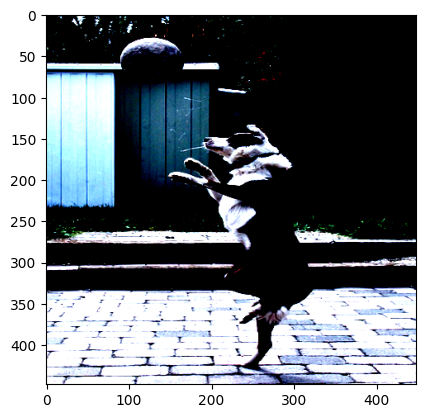

In [6]:
# Inspect some images and captions
dataset.print_random_image()

### Data Preparation

#### Image Embeddings

In [7]:
# Create a custom Dataset class for image embeddings batch processing
class ImagesDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_ids = self._get_image_ids()
        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.image_ids)
    
    def _get_image_ids(self):
        image_ids = []
        for image_id in os.listdir(self.image_dir):
            image_ids.append(image_id)
        return image_ids

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = Image.open(os.path.join(self.image_dir, image_id)).convert('RGB')
        image = self.transform(image)
        return image_id, image

In [8]:
# Load the ResNet model
model = resnet101(weights=ResNet101_Weights.DEFAULT)
model = model.to(device)
model = model.eval()

# Remove the last layer of the model
model = nn.Sequential(*list(model.children())[:-1])

# Initialize the dataset
image_dir = 'data/Flickr30k/Images'
images_dataset = ImagesDataset(image_dir)

# Initialize the DataLoader
images_dataloader = DataLoader(images_dataset, batch_size=128, shuffle=False)

# Extract image embeddings
image_embeddings = {}
for image_ids, images in tqdm(images_dataloader, desc="Embedding images"):
    images = images.to(device)
    with torch.no_grad():
        embeddings = model(images)
    for i in range(len(image_ids)):
        image_embeddings[image_ids[i]] = embeddings[i].cpu().numpy().flatten()

In [9]:
# Save the image embeddings dictionary for future runs of the notebook
with open('data/image_embeddings_30k.pkl', 'wb') as f:
    pickle.dump(image_embeddings, f)

In [10]:
# Load the saved image embeddings as a dictionary
with open('data/image_embeddings_30k.pkl', 'rb') as f:
    image_embeddings = pickle.load(f)

#### Full Dataset

In [11]:
# Create a custom Dataset class for the embedding of captions
class Flickr30kDataset(Dataset):
    def __init__(self, captions_dir, image_embeddings):
        self.captions_dir = captions_dir
        self.captions = self._load_captions(captions_dir)
        self.image_embeddings = image_embeddings
    
    def _load_captions(self, captions_dir):
        captions = []
        with open(captions_dir, 'r') as f:
            next(f)  # Skip the header
            for line in f:
                image_id = line.strip().split(',')[0]
                caption = ' '.join(line.strip().split(',')[1:])
                caption = self._preprocess_caption(caption)
                captions.append((image_id, caption))
        return captions
    
    def _preprocess_caption(self, caption):
        # Remove " and . characters
        caption = re.sub(f'["]', '', caption)
        caption = re.sub(f'[.]', '', caption)
        # Replace multiple spaces with a single space
        caption = re.sub(r'\s+', ' ', caption)
        # Strip leading/trailing whitespace
        caption = caption.strip()
        # Convert to lowercase
        caption = caption.lower()
        return caption
    
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_id, caption = self.captions[idx]
        image_embedding = self.image_embeddings[image_id]
        return image_id, caption, image_embedding

In [12]:
captions_dir = 'data/captions.txt'
dataset = Flickr30kDataset(captions_dir, image_embeddings)

In [13]:
dataset.captions

[('1000268201_693b08cb0e.jpg',
  'a child in a pink dress is climbing up a set of stairs in an entry way'),
 ('1000268201_693b08cb0e.jpg', 'a girl going into a wooden building'),
 ('1000268201_693b08cb0e.jpg',
  'a little girl climbing into a wooden playhouse'),
 ('1000268201_693b08cb0e.jpg',
  'a little girl climbing the stairs to her playhouse'),
 ('1000268201_693b08cb0e.jpg',
  'a little girl in a pink dress going into a wooden cabin'),
 ('1001773457_577c3a7d70.jpg', 'a black dog and a spotted dog are fighting'),
 ('1001773457_577c3a7d70.jpg',
  'a black dog and a tri-colored dog playing with each other on the road'),
 ('1001773457_577c3a7d70.jpg',
  'a black dog and a white dog with brown spots are staring at each other in the street'),
 ('1001773457_577c3a7d70.jpg',
  'two dogs of different breeds looking at each other on the road'),
 ('1001773457_577c3a7d70.jpg',
  'two dogs on pavement moving toward each other'),
 ('1002674143_1b742ab4b8.jpg',
  'a little girl covered in paint s

#### Create Data Split

In [14]:
# Get all the unique image IDs from the dictionary
image_ids = list(image_embeddings.keys())

# Split image IDs into train/dev/test sets (80/10/10)
train_image_ids, test_image_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
test_image_ids, val_image_ids = train_test_split(test_image_ids, test_size=0.5, random_state=42)

# Function to create subsets based on image IDs
def create_subset(dataset, image_ids):
    indices = [idx for idx, (image_id, _, _) in enumerate(dataset) if image_id in image_ids]
    return Subset(dataset, indices)

# Create training and testing subsets
train_dataset = create_subset(dataset, train_image_ids)
val_dataset = create_subset(dataset, val_image_ids)
test_dataset = create_subset(dataset, test_image_ids)

In [15]:
# Count unique image IDs from the training dataset to verify validity
train_image_ids = [image_id for image_id, _, _ in train_dataset]
val_image_ids = [image_id for image_id, _, _ in val_dataset]
test_image_ids = [image_id for image_id, _, _ in test_dataset]
len(set(train_image_ids)), len(set(val_image_ids)), len(set(test_image_ids))

(6472, 810, 809)

### Implement Model

#### Caption Embedding (GloVe)

In [16]:
# Use nltk and GloVe embeddings to embed the captions (Embeddings: https://nlp.stanford.edu/data/glove.6B.zip)

# Download necessary NLTK data
nltk.download('punkt')

from nltk.tokenize import word_tokenize

# Load GloVe embeddings
def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Initialize GloVe embeddings
glove_embeddings = load_glove_embeddings('data/glove.6B.300d.txt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jasper\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
def build_vocabulary(captions):
    vocab = set()
    for _, caption in captions:
        tokens = word_tokenize(caption.lower())
        vocab.update(tokens)
    return list(vocab)

In [18]:
# Build the vocabulary from the dataset captions
vocabulary = build_vocabulary(dataset.captions)
vocabulary = ['<pad>', '<start>', '<stop>', '<unk>'] + vocabulary
vocabulary[:10]

['<pad>',
 '<start>',
 '<stop>',
 '<unk>',
 'screams',
 'retrievers',
 'fetching',
 'sillhouetted',
 'acrobat',
 'rottwieler']

In [19]:
def create_vocab_embeddings(glove_embeddings, vocabulary):
    filtered_embeddings = {}
    for word in vocabulary:
        if word in glove_embeddings:
            filtered_embeddings[word] = glove_embeddings[word]
        elif word == '<pad>':
            filtered_embeddings[word] = np.zeros(300)
        else:
            filtered_embeddings[word] = np.random.normal(scale=0.6, size=(300,))  # Assuming GloVe vectors are 300-dimensional
    return filtered_embeddings

In [20]:
# Filter the GloVe embeddings to only include words from the vocabulary
vocab_embeddings = create_vocab_embeddings(glove_embeddings, vocabulary)

In [21]:
# Function to create a word to index mapping
def create_word_to_index(vocab):
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    return word_to_index

# Create an index to word mapping
def create_index_to_word(vocab):
    index_to_word = {idx: word for idx, word in enumerate(vocab)}
    return index_to_word

In [22]:
word_to_index = create_word_to_index(vocab_embeddings.keys())
index_to_word = create_index_to_word(vocab_embeddings.keys())

In [23]:
def create_embedding_matrix(vocab_embeddings, word_to_index):
    embedding_matrix = np.zeros((len(word_to_index), 300))
    for word, idx in word_to_index.items():
        embedding_matrix[idx] = vocab_embeddings[word]
    return embedding_matrix

In [24]:
embedding_matrix = create_embedding_matrix(vocab_embeddings, word_to_index)

In [25]:
class CaptionEmbedding(nn.Module):
    def __init__(self, word_to_index, embedding_matrix, max_len=16):
        super(CaptionEmbedding, self).__init__()
        self.word_to_index = word_to_index
        self.embedding_matrix = embedding_matrix
        self.max_len = max_len
        self.embedding_dim = embedding_matrix.shape[1]

        # Positional embedding
        self.token_embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.position_embedding = nn.Embedding(max_len, self.embedding_dim)

    def tokenize(self, captions, input=True):
        # Tokenize the caption and add special tokens. 
        # Input has no <stop> token and label has not <start> token (right shifted).
        # Function returns sequence of token IDs with padding.
        tokenized_captions = []
        for caption in captions:
            if input == True:
                tokens = ['<start>'] + word_tokenize(caption.lower())
            else:
                tokens = word_tokenize(caption.lower()) + ['<stop>']
            if len(tokens) < self.max_len:
                tokens += ['<pad>'] * (self.max_len - len(tokens))
            else:
                tokens = tokens[:self.max_len]
            # Transform tokens to token IDs
            token_ids = [self.word_to_index.get(token, self.word_to_index['<unk>']) for token in tokens]
            tokenized_captions.append(token_ids)
        return tokenized_captions

    def forward(self, token_ids):
        batch_size = len(token_ids)

        # Get token embeddings and position embeddings for the token IDs
        token_embeddings = self.token_embedding(token_ids)
        positions = torch.arange(0, self.max_len).unsqueeze(0).expand(batch_size, self.max_len).to(device)
        position_embeddings = self.position_embedding(positions)
        embeddings = token_embeddings + position_embeddings # (batch_size, max_len, embedding_dim)
        return embeddings

#### Transformer Decoder Block

##### Self Attention Layer

In [26]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, embed_size, heads, dropout=0.2):
        super(SelfAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_size, heads, dropout, batch_first=True)

    def forward(self, x, tgt_mask=None, tgt_key_padding_mask=None):
        attn_output, _ = self.multihead_attn(x, x, x, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        return attn_output

##### Cross Attention Layer

In [27]:
class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_size, heads, dropout=0.2):
        super(CrossAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_size, heads, dropout, batch_first=True)

    def forward(self, x, memory):
        attn_output, _ = self.multihead_attn(x, memory, memory) # (Q, K, V)
        # (Memory is the feature vector of the image and x the output of the self-attention layer)
        return attn_output

##### Feed-Forward Layer

In [28]:
class FeedForwardLayer(nn.Module):
    def __init__(self, embed_size, ff_hidden_size, dropout):
        super(FeedForwardLayer, self).__init__()
        self.ff = nn.Sequential(
            nn.Linear(embed_size, ff_hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(ff_hidden_size, embed_size)
        )

    def forward(self, x):
        return self.ff(x)

##### Full Decoder Block

In [29]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden_size, dropout):
        super(TransformerDecoderBlock, self).__init__()
        self.layer_norm = nn.LayerNorm(embed_size)
        self.self_attention = SelfAttentionLayer(embed_size, heads)
        self.cross_attention = CrossAttentionLayer(embed_size, heads)
        self.feed_forward = FeedForwardLayer(embed_size, ff_hidden_size, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, tgt_mask=None, tgt_key_padding_mask=None):
        # Self-attention
        _x = x # Residual connection
        x = self.self_attention(x, tgt_mask, tgt_key_padding_mask)
        x = self.dropout(x)
        x = self.layer_norm(x + _x)

        # Cross-attention
        _x = x # Residual connection
        x = self.cross_attention(x, memory)
        x = self.dropout(x)
        x = self.layer_norm(x + _x)

        # Feed-forward
        _x = x # Residual connection
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = self.layer_norm(x + _x)

        return x

##### Transformer Decoder

In [30]:
class TransformerDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, heads, ff_hidden_size, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerDecoderBlock(embed_size, heads, ff_hidden_size, dropout)
        for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(embed_size)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None):
        x = tgt
        for layer in self.layers:
            x = layer(x, memory, tgt_mask, tgt_key_padding_mask)
        return self.layer_norm(x)

#### Full Model
Uses greedy decoding for caption generation

In [31]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, image_feat_dim, embedding_dim, num_layers, heads, ff_hidden_size, vocab_size, dropout, max_len=20):
        super(ImageCaptioningModel, self).__init__()
        self.image_proj = nn.Linear(image_feat_dim, embedding_dim)
        self.caption_embedding = CaptionEmbedding(word_to_index, embedding_matrix, max_len)
        self.decoder = TransformerDecoder(embedding_dim, num_layers, heads, ff_hidden_size, dropout)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

    def forward(self, input_ids, image_features, tgt_mask=None, tgt_key_padding_mask=None):
        # Project image features to the embedding dimension
        memory = self.image_proj(image_features)  # (batch_size, embedding_dim)
        memory = memory.unsqueeze(1)  # Add sequence dimension: (batch_size, 1, embedding_dim)
        
        # Embedding and adding positional encoding for captions
        captions_embedded = self.caption_embedding(input_ids)  # (batch_size, seq_len, embedding_dim)

        # Create causal mask and padding mask for the decoder
        if tgt_mask is None:
            tgt_mask = torch.triu(torch.ones(self.max_len, self.max_len), diagonal=1).bool().to(device)
        if tgt_key_padding_mask is None:
            tgt_key_padding_mask = (input_ids == 0).to(device)
        
        # Pass through the decoder
        decoder_output = self.decoder(captions_embedded, memory, tgt_mask, tgt_key_padding_mask)  # (batch_size, seq_len, embedding_dim)
        
        # Generate predictions for the next token
        output = self.output_layer(decoder_output)  # (batch_size, seq_len, vocab_size)
        return output

    def generate_captions(self, image_features):
        batch_size = image_features.size(0)
        input_ids = torch.full((batch_size, self.max_len), 0, dtype=torch.long, device=device)
        input_ids[:, 0] = 1

        for t in range(1, self.max_len):
            # Generate tgt_mask for the current sequence length
            tgt_mask = torch.triu(torch.ones((self.max_len, self.max_len)), diagonal=1).bool().to(device)

            # Get the predictions for the next token
            output = self.forward(input_ids, image_features, tgt_mask=tgt_mask)

            # Get the token with the highest probability
            next_token = output[:, t-1].argmax(dim=-1)

            # Add the next token to the captions
            input_ids[:, t] = next_token

            # Stop generation if all sequences in the batch have generated the <stop> token
            if (next_token == 2).all():
                break
        
        # Convert token IDs to words and cut off anyting after the <stop> token
        captions = []
        for seq in input_ids:
            caption = []
            for token_id in seq[1:]:
                if token_id == 2:
                    break
                token = index_to_word[token_id.item()]
                caption.append(token)
            captions.append(' '.join(caption))
        return captions

In [32]:
# Generate caption for a random image
image_id, caption, image_embedding = dataset[0]
image_embedding = torch.tensor(image_embedding).unsqueeze(0).to(device)
model = ImageCaptioningModel(image_feat_dim=2048, embedding_dim=300, num_layers=2, heads=2, ff_hidden_size=512, vocab_size=len(vocab_embeddings), dropout=0.2, max_len=16).to(device)
model.generate_captions(image_embedding)

['saharan floor snowdrift retrievers grove devotion extinguishes clothing woven stove pairs him dusted pocket pawing']

### Initialize Model

In [124]:
# Model parameters
image_feat_dim = 2048  # ResNet's image feature vector size
embedding_dim = 300  # GloVe embedding size
vocab_size = len(vocabulary)

# Hyperparameters
num_layers = 4
heads = 3
ff_hidden_size = 32
dropout = 0.5
max_len = 25

In [125]:
# Initialize model
model = ImageCaptioningModel(image_feat_dim=image_feat_dim, embedding_dim=embedding_dim, num_layers=num_layers,
                             heads=heads, ff_hidden_size=ff_hidden_size, vocab_size=vocab_size, dropout=dropout, max_len=max_len).to(device)

In [126]:
# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 8949641


### Training Loop
Uses validation loss and early stopping to prevent overfitting

In [127]:
# Set model name and results directory
MODEL_NAME = 'Model_v7_4layers_3heads_32ff_0.5dropout_25maxlen_____1e-3lr_200epochs_256batchsize_5patience'
RESULTS_DIR = 'models/Flickr30k/v7'

In [128]:
# Training hyperparameters
lr = 1e-3
num_epochs = 200
patience = 5
batch_size = 256

In [129]:
# Initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [130]:
# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Specify loss function
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [132]:
def train_model_with_early_stopping(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience, vocab_size, results_dir, model_name):
    global epoch_train_loss, epoch_val_loss
    epoch_train_loss, epoch_val_loss = [], []
    best_val_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (image_ids, captions, image_features) in enumerate(train_dataloader):
            optimizer.zero_grad()

            # Convert image features to tensor
            image_features = image_features.to(device) # (batch_size, image_feat_dim)

            # Tokenize and encode captions
            input_ids = torch.tensor(model.caption_embedding.tokenize(captions, input=True), dtype=torch.float32).long().to(device)
            target_ids = torch.tensor(model.caption_embedding.tokenize(captions, input=False), dtype=torch.float32).long().to(device)

            # Forward pass
            outputs = model(input_ids, image_features)

            # Compute loss
            outputs = outputs.view(-1, vocab_size)
            target_ids = target_ids.view(-1)
            loss = criterion(outputs, target_ids)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 50 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss:.4f}")

        avg_epoch_loss = running_loss / len(train_dataloader)
        epoch_train_loss.append(avg_epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for image_ids, captions, image_features in val_dataloader:
                image_features = image_features.to(device)
                input_ids = torch.tensor(model.caption_embedding.tokenize(captions, input=True), dtype=torch.float32).long().to(device)
                target_ids = torch.tensor(model.caption_embedding.tokenize(captions, input=False), dtype=torch.float32).long().to(device)

                outputs = model(input_ids, image_features)
                outputs = outputs.view(-1, vocab_size)
                target_ids = target_ids.view(-1)
                loss = criterion(outputs, target_ids)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        epoch_val_loss.append(avg_val_loss)

        print(f"\n\n----------------EPOCH [{epoch + 1}/{num_epochs}], AVG TRAIN LOSS: {avg_epoch_loss:.4f}, AVG VAL LOSS: {avg_val_loss:.4f}----------------\n")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best model
            if not os.path.exists(results_dir):
                os.makedirs(results_dir)
            best_model_path = os.path.join(results_dir, f'BEST_{model_name}.pt')
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

        # Save model checkpoint after each epoch
        model_path = os.path.join(results_dir, f'EPOCH{epoch + 1}_{model_name}.pt')
        torch.save(model.state_dict(), model_path)

    print("Training complete.")

In [133]:
train_model_with_early_stopping(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience, vocab_size=vocab_size, results_dir=RESULTS_DIR, model_name=MODEL_NAME)

Epoch [1/200], Batch [0/127], Loss: 9.2814
Epoch [1/200], Batch [50/127], Loss: 4.8446
Epoch [1/200], Batch [100/127], Loss: 4.1025


----------------EPOCH [1/200], AVG TRAIN LOSS: 4.8057, AVG VAL LOSS: 3.8239----------------

Epoch [2/200], Batch [0/127], Loss: 3.7485
Epoch [2/200], Batch [50/127], Loss: 3.5573
Epoch [2/200], Batch [100/127], Loss: 3.4643


----------------EPOCH [2/200], AVG TRAIN LOSS: 3.5998, AVG VAL LOSS: 3.4384----------------

Epoch [3/200], Batch [0/127], Loss: 3.4252
Epoch [3/200], Batch [50/127], Loss: 3.2524
Epoch [3/200], Batch [100/127], Loss: 3.0913


----------------EPOCH [3/200], AVG TRAIN LOSS: 3.2192, AVG VAL LOSS: 3.2444----------------

Epoch [4/200], Batch [0/127], Loss: 3.0542
Epoch [4/200], Batch [50/127], Loss: 2.9963
Epoch [4/200], Batch [100/127], Loss: 2.9128


----------------EPOCH [4/200], AVG TRAIN LOSS: 2.9788, AVG VAL LOSS: 3.1640----------------

Epoch [5/200], Batch [0/127], Loss: 2.8410
Epoch [5/200], Batch [50/127], Loss: 2.7531
Epoch

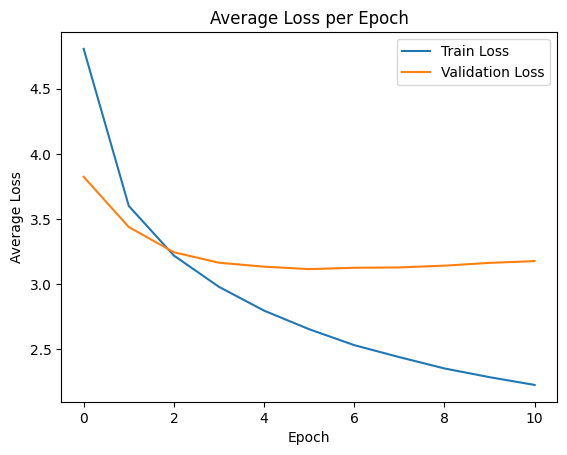

In [134]:
# Plot loss curve of average train and val loss over epochs
plt.plot(epoch_train_loss, label='Train Loss')
plt.plot(epoch_val_loss, label='Validation Loss')
plt.title("Average Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()

# Save the loss curve plot
plt.savefig(os.path.join(RESULTS_DIR, f'{MODEL_NAME}_loss_curve.png'))

### Model Evaluation

In [135]:
model.eval()

ImageCaptioningModel(
  (image_proj): Linear(in_features=2048, out_features=300, bias=True)
  (caption_embedding): CaptionEmbedding(
    (token_embedding): Embedding(8913, 300)
    (position_embedding): Embedding(25, 300)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderBlock(
        (layer_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (self_attention): SelfAttentionLayer(
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
          )
        )
        (cross_attention): CrossAttentionLayer(
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
          )
        )
        (feed_forward): FeedForwardLayer(
          (ff): Sequential(
            (0): Linear(in_features=300, out_features=32, bias=True)
            (1): Dro

In [136]:
# Initialize test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [137]:
def print_image(image_id, caption, pred_caption, image_dir):
    image = Image.open(os.path.join(image_dir, image_id)).convert('RGB')
    plt.imshow(image)
    plt.title(f"ACTUAL: {caption}\nPREDICTED: {pred_caption}")
    plt.axis('off')
    plt.show()

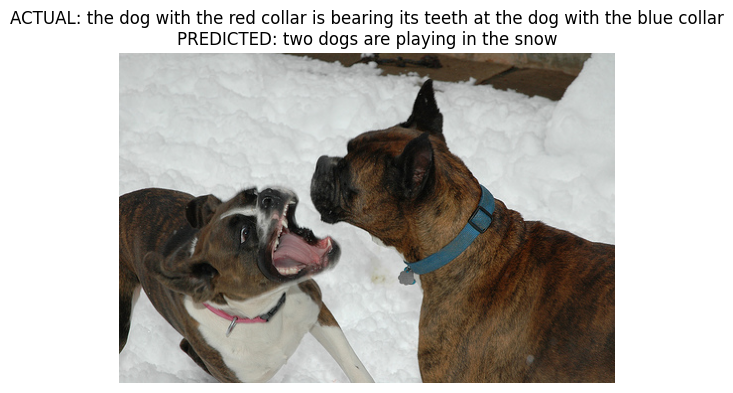

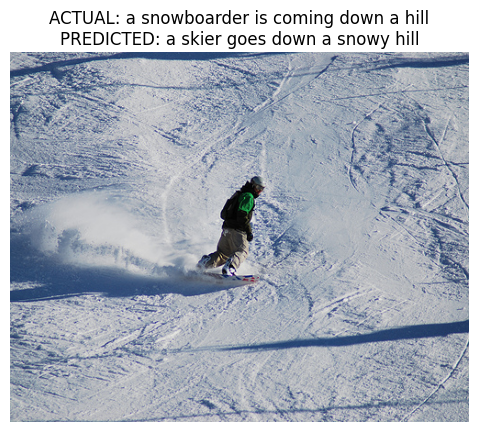

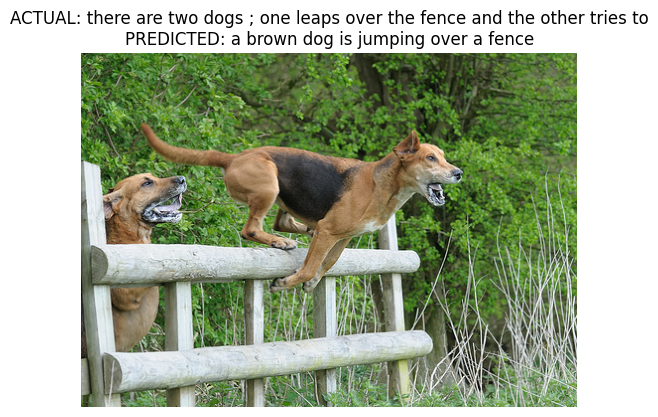

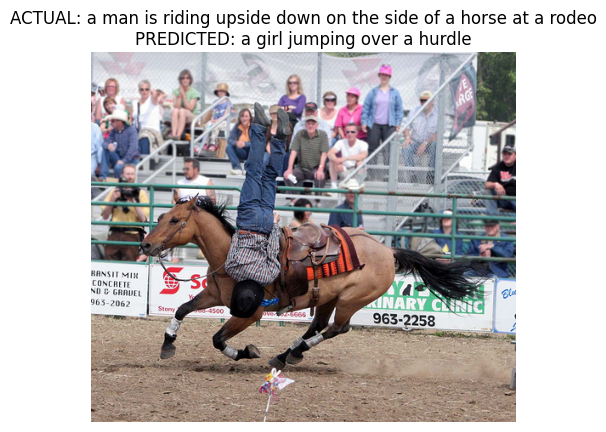

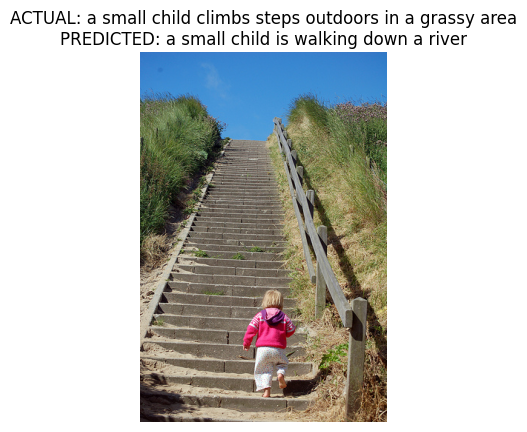

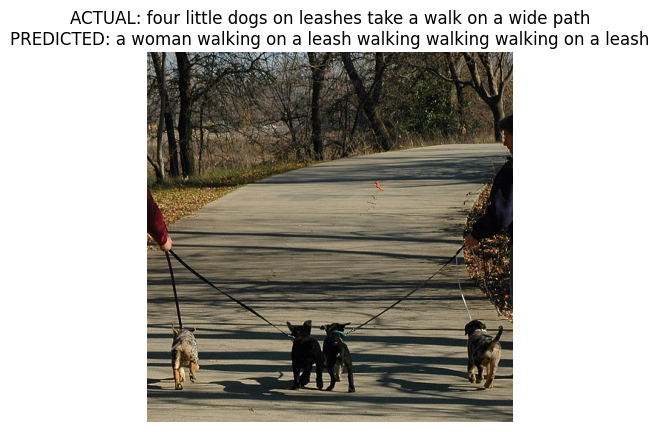

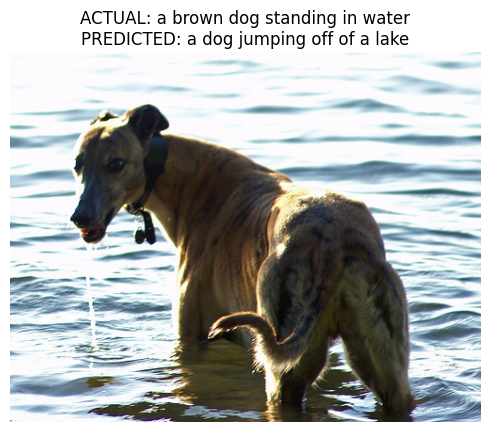

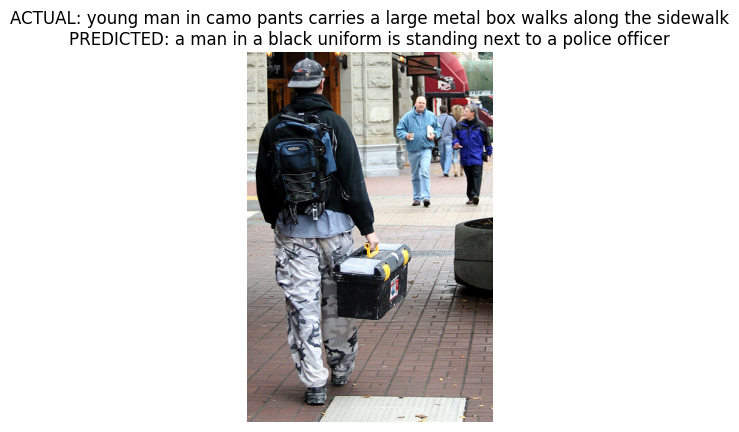

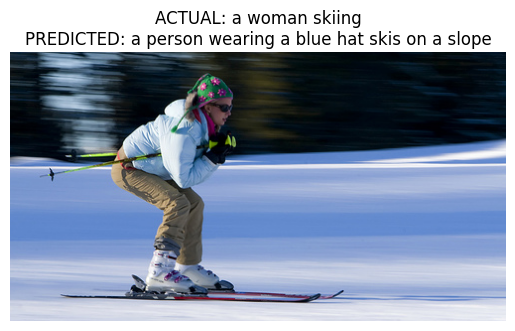

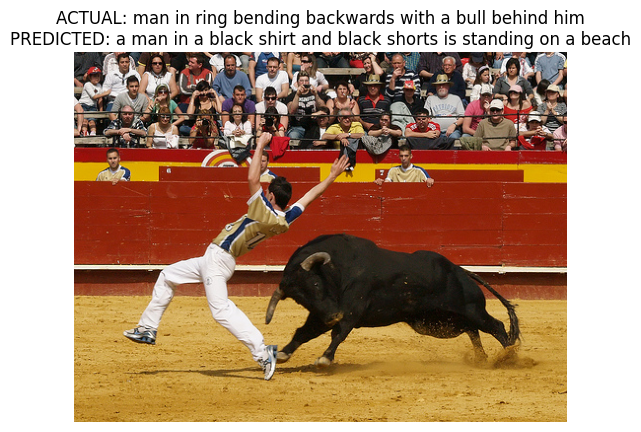

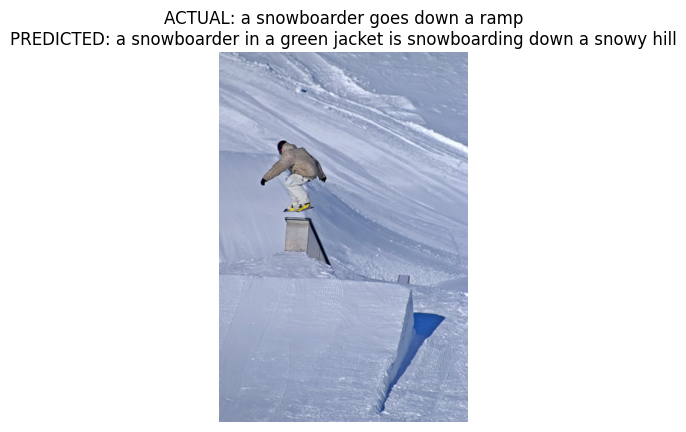

In [140]:
for batch_idx, (image_ids, captions, image_features) in enumerate(test_dataloader):
    # Convert image features to tensor
    image_features = image_features.to(device) # (batch_size, image_feat_dim)

    # Generate captions
    pred_captions = model.generate_captions(image_features)

    # Print images and captions
    print_image(image_ids[0], captions[0], pred_captions[0], image_dir)

    if batch_idx == 10:
        break

In [139]:
pred_captions

['a skier goes down a snowy hill',
 'a white dog runs along a dirt path',
 'a brown dog is running through the grass',
 'a person in a wetsuit is jumping into a swimming pool',
 'a man in a blue shirt climbs a rock',
 'a woman in a field with a white shirt and brown shirt is standing in front of a field',
 'a woman in a black shirt is holding a rope pole',
 'a person in a blue shirt is riding a dirt bike',
 'a boy in a blue shirt is skateboarding on a concrete wall',
 'a man in a blue jacket is skiing down a snowy hill']